In [11]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import pandas as pd
import numpy as np
import json
import cv2
import os

# Data preparation

## CSV and JSON data (Data info)

In [2]:
INPUT_PATH = os.path.join('..', 'data', 'eyes_cursor')

data_info = None
for sub_num, subject in enumerate(os.listdir(INPUT_PATH)):
    for ses_num, session in enumerate(os.listdir(os.path.join(INPUT_PATH, subject))):
        csv_path = glob(os.path.join(INPUT_PATH, subject, session, '*.csv'))[0]
        json_path = glob(os.path.join(INPUT_PATH, subject, session, '*.json'))[0]

        # Loading data
        temp_df = pd.read_csv(csv_path)
        with open(json_path, 'r') as file:
            session_data = json.load(file)
        assert session_data['images']==temp_df.shape[0], f'Incorrect number of images in:\n{subject}\n{session}'

        # Creating new columns
        temp_df['subject'] = ['subject_'+str(sub_num)]*session_data['images']
        temp_df['file_name'] = temp_df['file_name'].apply(lambda x: os.path.join(INPUT_PATH, subject, session, 'images', x))
        temp_df = temp_df.rename(columns={'file_name':'file_path'})

        # Normalizing data
        temp_df[['ref_x', 'ref_w']] = temp_df[['ref_x', 'ref_w']] / session_data['im_width']
        temp_df[['ref_y', 'ref_h']] = temp_df[['ref_y', 'ref_h']] / session_data['im_height']
        temp_df['click_x'] = temp_df['click_x'] / session_data['screen_width']
        temp_df['click_y'] = temp_df['click_y'] / session_data['screen_height']

        if sub_num==0 and ses_num==0:
            data_info = temp_df
        else:
            data_info = pd.concat([data_info,temp_df], axis=0)
data_info = data_info.reset_index().drop('index',axis=1)

data_info.head()

,file_path,ref_x,ref_y,ref_w,ref_h,click_x,click_y,subject
0,../data/eyes_cursor/subject_1/2023_09_04-11_03...,0.451562,0.464583,0.175000,0.097917,0.003125,0.003333,subject_0
1,../data/eyes_cursor/subject_1/2023_09_04-11_03...,0.446875,0.464583,0.179688,0.100000,0.073438,0.010000,subject_0
2,../data/eyes_cursor/subject_1/2023_09_04-11_03...,0.448437,0.464583,0.181250,0.100000,0.141667,0.007500,subject_0
3,../data/eyes_cursor/subject_1/2023_09_04-11_03...,0.448437,0.462500,0.181250,0.100000,0.232292,0.008333,subject_0
4,../data/eyes_cursor/subject_1/2023_09_04-11_03...,0.448437,0.462500,0.175000,0.097917,0.284896,0.012500,subject_0


In [3]:
data_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3135 entries, 0 to 3134
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   file_path  3135 non-null   object 
 1   ref_x      3135 non-null   float64
 2   ref_y      3135 non-null   float64
 3   ref_w      3135 non-null   float64
 4   ref_h      3135 non-null   float64
 5   click_x    3135 non-null   float64
 6   click_y    3135 non-null   float64
 7   subject    3135 non-null   object 
dtypes: float64(6), object(2)
memory usage: 196.1+ KB


In [4]:
data_info.describe()

,ref_x,ref_y,ref_w,ref_h,click_x,click_y
count,3135.000000,3135.000000,3135.000000,3135.000000,3135.000000,3135.000000
mean,0.423565,0.371007,0.204363,0.113111,0.501545,0.491072
std,0.086022,0.101322,0.034963,0.019414,0.307657,0.310128
min,0.164062,0.129167,0.110937,0.060417,0.000000,0.000000
25%,0.384375,0.287500,0.178125,0.097917,0.227899,0.198125
50%,0.425000,0.412500,0.193750,0.108333,0.491215,0.497396
75%,0.454688,0.464583,0.220312,0.122917,0.777789,0.772135
max,0.814063,0.618750,0.351562,0.193750,0.999479,0.998698


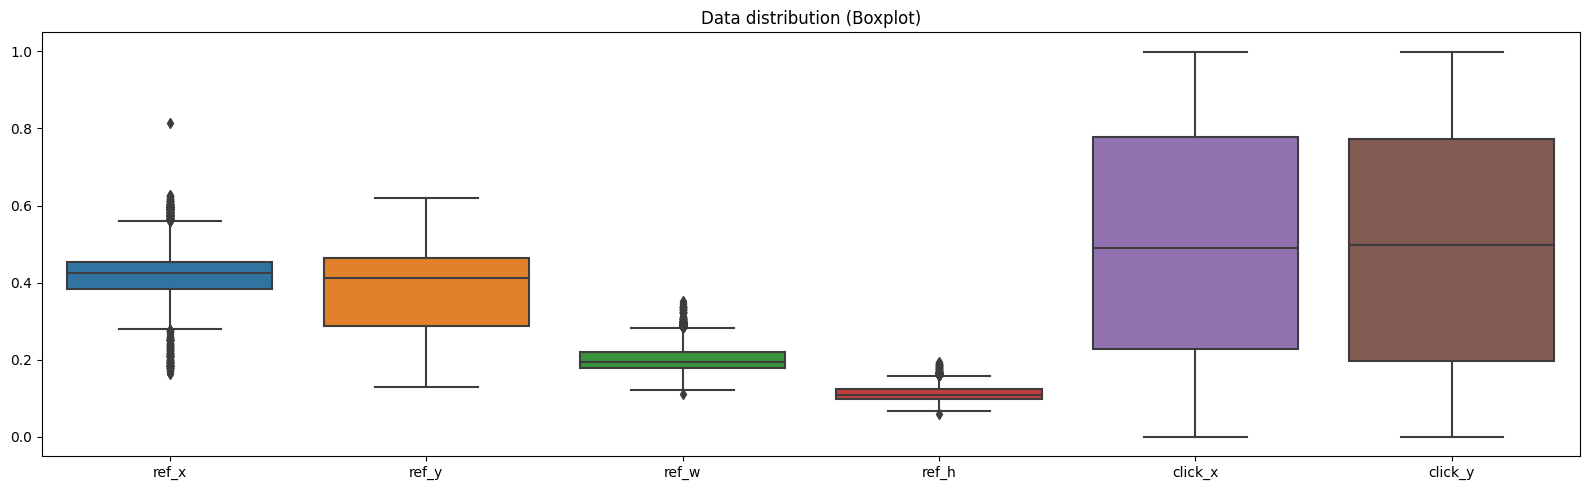

In [5]:
plt.figure(figsize=(16,5))
sns.boxplot(data_info)
plt.title('Data distribution (Boxplot)')
plt.tight_layout()
plt.show()

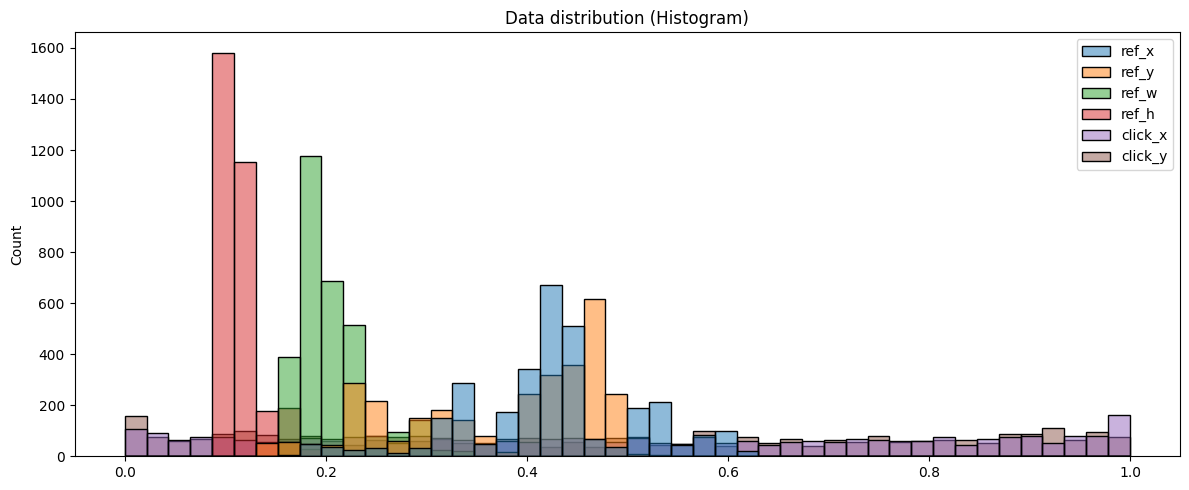

In [6]:
plt.figure(figsize=(12,5))
sns.histplot(data_info)
plt.title('Data distribution (Histogram)')
plt.tight_layout()
plt.show()

## Eyes capture (Images)

In [7]:
size = (130, 50)
images = np.zeros((data_info.shape[0], size[1], size[0], 3))
for i, image_path in enumerate(data_info['file_path']):
    image  = plt.imread(image_path)
    images[i] = cv2.resize(image, size)
images = images/255
images.shape

(3135, 50, 130, 3)

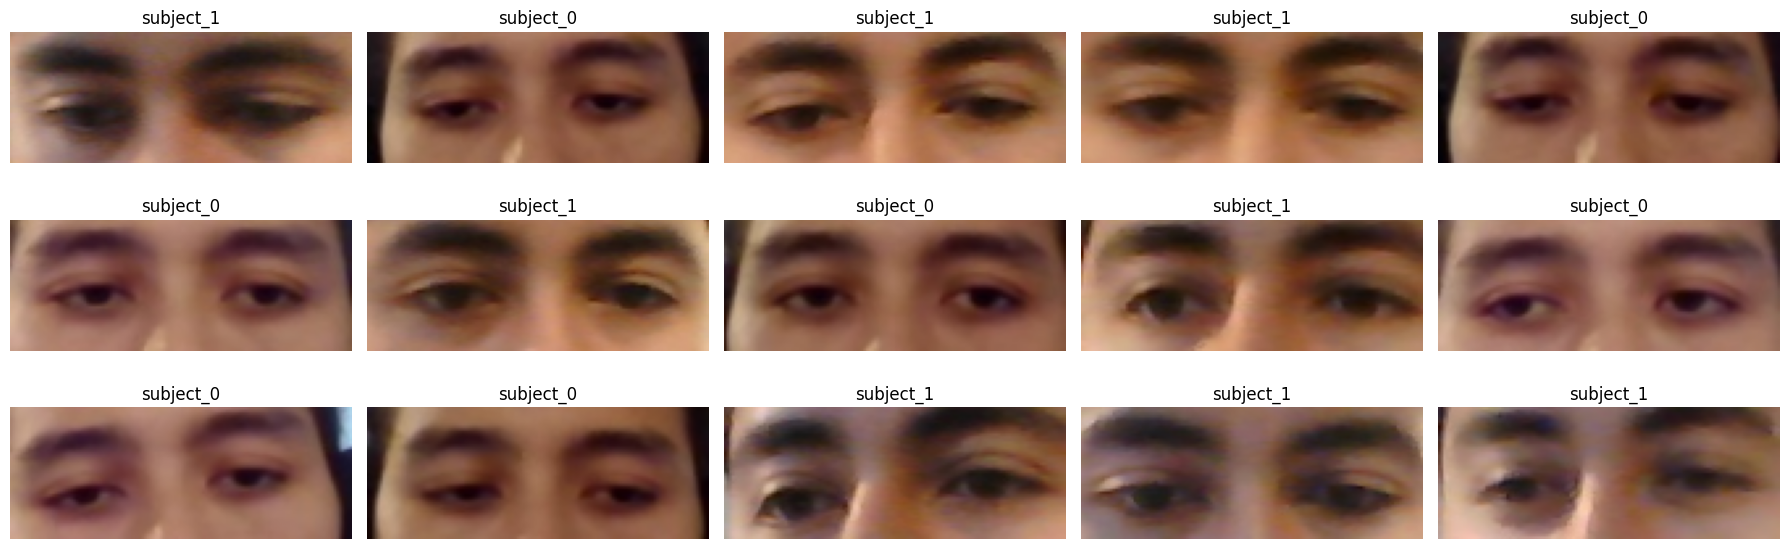

In [10]:
fig, axes = plt.subplots(3, 5, figsize=(18,6))
for i, ax in enumerate(axes.flatten()):
    idx = np.random.randint(0, data_info.shape[0])
    ax.imshow(images[idx])
    ax.set_title(f"{data_info['subject'].iloc[idx]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

# Model creation

In [13]:
X_img_tr, X_img_ts, X_info_tr, X_info_ts, y_tr, y_ts = train_test_split(images,
                                                                        data_info[['ref_x', 'ref_y', 'ref_w', 'ref_h']],
                                                                        data_info[['click_x', 'click_y']],
                                                                        test_size = 0.2,
                                                                        random_state = 69)

X_img_tr.shape, X_img_ts.shape, X_info_tr.shape, X_info_ts.shape, y_tr.shape, y_ts.shape

((2508, 50, 130, 3),
 (627, 50, 130, 3),
 (2508, 4),
 (627, 4),
 (2508, 2),
 (627, 2))